In [113]:
%matplotlib inline

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import gymnasium as gym
from gymnasium import Env, spaces
from scipy.special import comb
from collections import defaultdict

# Deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [115]:
with open('pickles/anonbank_lognorm_params.pkl', 'rb') as f:
    lognorm_params_df = pickle.load(f)
    
lognorm_params_dict = lognorm_params_df.set_index('param_name').T.to_dict()

lognorm_params_dict

{('1', 'REGULAR'): {'mu': 4.832017135463374,
  'sigma': 0.006958469079704907,
  'loc': -18.81216413263904},
 ('1', 'SPECIFIC'): {'mu': 4.6755415208149325,
  'sigma': 0.011323646523065594,
  'loc': -6.43006717763892},
 ('2', 'REGULAR'): {'mu': 5.0125526231624855,
  'sigma': 0.005548307071802354,
  'loc': -8.97654648869145},
 ('2', 'SPECIFIC'): {'mu': 4.617186601308905,
  'sigma': 0.010134016947128502,
  'loc': -4.806412598886724},
 'REGULAR': {'mu': 3.7589339214345716,
  'sigma': 0.024480564633599006,
  'loc': -2.846758403840244},
 'SPECIFIC': {'mu': 4.650110366782741,
  'sigma': 0.01083819523964822,
  'loc': -5.260938954957395},
 'REGULAR_x4': {'mu': 5.145228282554465,
  'sigma': 0.006121000886257698,
  'loc': -11.387033615361277},
 'SPECIFIC_x4': {'mu': 6.036404727902634,
  'sigma': 0.002709623408600959,
  'loc': -21.043755819830228}}

In [116]:
with open('pickles/anonbank_service_rate.pkl', 'rb') as f:
    service_rate = pickle.load(f)

# Convert service_rate to a dictionary for easier access
ser_rate_dict = service_rate.set_index(['group', 'type_group'])[['mean_service_time', 'std']].to_dict('index')

ser_rate_dict

{('1', 'REGULAR'): {'mean_service_time': 12.641068214208262,
  'std': 274.09685054233046},
 ('1', 'SPECIFIC'): {'mean_service_time': 14.229164478664519,
  'std': 447.916748807343},
 ('2', 'REGULAR'): {'mean_service_time': 19.02417781821472,
  'std': 344.9407640049321},
 ('2', 'SPECIFIC'): {'mean_service_time': 15.020757462895316,
  'std': 257.32365209990894}}

In [117]:

# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Discount factor for future rewards
DISCOUNT = 0.95

# Penalty for dropping calls (when queue is full)
DROP_PENALTY = 3600.0 # 1 hour in seconds

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)

# Call type: 0 = regular, 1 = specific
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [1, 2]

# Arrival parameters for regular and specific calls
ARRIVAL_REGULAR_MU = lognorm_params_dict['REGULAR']['mu']
ARRIVAL_REGULAR_SIGMA = lognorm_params_dict['REGULAR']['sigma']
ARRIVAL_REGULAR_LOC = lognorm_params_dict['REGULAR']['loc']
ARRIVAL_SPECIFIC_MU = lognorm_params_dict['SPECIFIC']['mu']
ARRIVAL_SPECIFIC_SIGMA = lognorm_params_dict['SPECIFIC']['sigma']
ARRIVAL_SPECIFIC_LOC = lognorm_params_dict['SPECIFIC']['loc']

SERVICE_REGULAR_1_MU = lognorm_params_dict[('1', 'REGULAR')]['mu']
SERVICE_REGULAR_1_SIGMA = lognorm_params_dict[('1', 'REGULAR')]['sigma']
SERVICE_REGULAR_1_LOC = lognorm_params_dict[('1', 'REGULAR')]['loc']
SERVICE_SPECIFIC_1_MU = lognorm_params_dict[('1', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_1_SIGMA = lognorm_params_dict[('1', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_1_LOC = lognorm_params_dict[('1', 'SPECIFIC')]['loc']

SERVICE_REGULAR_2_MU = lognorm_params_dict[('2', 'REGULAR')]['mu']
SERVICE_REGULAR_2_SIGMA = lognorm_params_dict[('2', 'REGULAR')]['sigma']
SERVICE_REGULAR_2_LOC = lognorm_params_dict[('2', 'REGULAR')]['loc']
SERVICE_SPECIFIC_2_MU = lognorm_params_dict[('2', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_2_SIGMA = lognorm_params_dict[('2', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_2_LOC = lognorm_params_dict[('2', 'SPECIFIC')]['loc']

def mean_shifted_lognormal(mu, sigma, loc):
    """
    Calculate mean of shifted lognormal distribution:
    E[X] = exp(mu + sigma^2 / 2) + loc
    """
    return np.exp(mu + (sigma**2) / 2) + loc

def std_shifted_lognormal(mu, sigma, loc):
    """
    Calculate standard deviation of shifted lognormal distribution:
    The location (loc) shifts the mean but does not affect the std.
    """
    return np.sqrt((np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2))

# Arrival rates

ARRIVAL_REGULAR = mean_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC
)

ARRIVAL_SPECIFIC = mean_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

ARRIVAL_REGULAR_STD = std_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC   
)

ARRIVAL_SPECIFIC_STD = std_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

# Service means and std

SERVICE_REGULAR_1 = ser_rate_dict[('1', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_1 = ser_rate_dict[('1', 'SPECIFIC')]['mean_service_time']
SERVICE_REGULAR_2 = ser_rate_dict[('2', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_2 = ser_rate_dict[('2', 'SPECIFIC')]['mean_service_time']

SERVICE_REGULAR_1_STD = ser_rate_dict[('1', 'REGULAR')]['std']
SERVICE_SPECIFIC_1_STD = ser_rate_dict[('1', 'SPECIFIC')]['std']
SERVICE_REGULAR_2_STD = ser_rate_dict[('2', 'REGULAR')]['std']
SERVICE_SPECIFIC_2_STD = ser_rate_dict[('2', 'SPECIFIC')]['std']

# SERVICE_REGULAR_1 = mean_shifted_lognormal(
#     SERVICE_REGULAR_1_MU,
#     SERVICE_REGULAR_1_SIGMA,
#     SERVICE_REGULAR_1_LOC
# )

# SERVICE_REGULAR_2 = mean_shifted_lognormal(
#     SERVICE_REGULAR_2_MU,
#     SERVICE_REGULAR_2_SIGMA,
#     SERVICE_REGULAR_2_LOC
# )

# SERVICE_SPECIFIC_1 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_1_MU,
#     SERVICE_SPECIFIC_1_SIGMA,
#     SERVICE_SPECIFIC_1_LOC
# )

# SERVICE_SPECIFIC_2 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_2_MU,
#     SERVICE_SPECIFIC_2_SIGMA,
#     SERVICE_SPECIFIC_2_LOC
# )

In [118]:
print("MEANS:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2}") 

print("STD:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR_STD}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC_STD}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1_STD}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1_STD}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2_STD}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2_STD}")

MEANS:
ARRIVAL_REGULAR: 40.068763243462236, ARRIVAL_SPECIFIC: 99.34173344076834
SERVICE_REGULAR_1: 12.641068214208262, SERVICE_SPECIFIC_1: 14.229164478664519
SERVICE_REGULAR_2: 19.02417781821472, SERVICE_SPECIFIC_2: 15.020757462895316
STD:
ARRIVAL_REGULAR: 1.050753626188135, ARRIVAL_SPECIFIC: 1.1337374798875093
SERVICE_REGULAR_1: 274.09685054233046, SERVICE_SPECIFIC_1: 447.916748807343
SERVICE_REGULAR_2: 344.9407640049321, SERVICE_SPECIFIC_2: 257.32365209990894


In [119]:
# Lognormal expected value calculation

def expected_waiting_time_binom_kingman(q_size, p_regular, mean_r, mean_s, rho, ca, cs):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    EWq = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        EWq += prob * wait_k
        
    # Kingman scaling
    Km = rho / (1 - rho) * (ca ** 2 + cs ** 2) / 2

    return EWq * Km

def expected_waiting_time_binom(q_size, p_regular, mean_r, mean_s):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    wait = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        wait += prob * wait_k

    return wait

def rho(rate_regular, rate_specific, mean_r, mean_s):
    """
    Calculate the traffic intensity (rho) for the queue.
    """
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_r) + (rate_specific / rate_total * mean_s)
    
    rhoo = rate_total * mean_comb
    if rhoo >= 1:
        return float('inf')  # Avoid division by zero or negative values
    return rhoo

def cv2(var, mean):
    return var / (mean ** 2)

def combined_ca2(rate_regular, rate_specific, ca_regular, ca_specific):
    """
    Calculate the combined coefficient of variation squared for the arrival process.
    """
    rate_total = rate_regular + rate_specific
    
    return (rate_regular / rate_total) * ca_regular + (rate_specific / rate_total) * ca_specific

def combined_cs2(mean_regular, mean_specific, cs_regular, cs_specific):
    """
    Calculate the combined coefficient of variation squared for the service process.
    """
    rate_regular = 1 / mean_regular
    rate_specific = 1 / mean_specific
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_regular) + (rate_specific / rate_total * mean_specific)
    
    term1 = (rate_regular / rate_total) * cs_regular
    term2 = (rate_specific / rate_total) * cs_specific
    term3 = rate_regular / rate_total * ((mean_regular - mean_comb) / mean_comb) ** 2
    term4 = rate_specific / rate_total * ((mean_specific - mean_comb) / mean_comb) ** 2
    
    return term1 + term2 + term3 + term4

In [120]:
# Example usage to calculate expected waiting time for queue 1:

rate_regular = 1 / ARRIVAL_REGULAR
rate_specific = 1 / ARRIVAL_SPECIFIC
rate_total = rate_regular + rate_specific

p_regular = rate_regular / rate_total

mean_r1 = SERVICE_REGULAR_1
mean_s1 = SERVICE_SPECIFIC_1

rho1 = rho(rate_regular, rate_specific, mean_r1, mean_s1)

meana_r = ARRIVAL_REGULAR
meana_s = ARRIVAL_SPECIFIC
vara_r = ARRIVAL_REGULAR_STD ** 2
vara_s = ARRIVAL_SPECIFIC_STD ** 2

ca_r = cv2(vara_r, meana_r)
ca_s = cv2(vara_s, meana_s)

vars_r1 = SERVICE_REGULAR_1_STD ** 2
vars_s1 = SERVICE_SPECIFIC_1_STD ** 2

cs_r1 = cv2(vars_r1, mean_r1)
cs_s1 = cv2(vars_s1, mean_s1)

ca = combined_ca2(rate_regular, rate_specific, ca_r, ca_s)
cs_1 = combined_cs2(mean_r1, mean_s1, cs_r1, cs_s1)

q_size = 10 # Example queue size

expected_wait = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r1, mean_s1, rho1, ca, cs_1)
print(f"Expected waiting time at queue 1 (Kingman): {expected_wait:.4f}")

# Compare with queue 2

mean_r2 = SERVICE_REGULAR_2
mean_s2 = SERVICE_SPECIFIC_2

rho2 = rho(rate_regular, rate_specific, mean_r2, mean_s2)

vars_r2 = SERVICE_REGULAR_2_STD ** 2
vars_s2 = SERVICE_SPECIFIC_2_STD ** 2

cs_r2 = cv2(vars_r2, mean_r2)
cs_s2 = cv2(vars_s2, mean_s2)

cs_2 = combined_cs2(mean_r2, mean_s2, cs_r2, cs_s2)

expected_wait2 = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r2, mean_s2, rho2, ca, cs_2)
print(f"Expected waiting time at queue 2 (Kingman): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Kingman): 28384089.2543
Expected waiting time at queue 2 (Kingman): 14287191.6796


In [121]:
expected_wait = expected_waiting_time_binom(q_size, p_regular, mean_r1, mean_s1)
print(f"Expected waiting time at queue 1 (Binom): {expected_wait:.4f}")
expected_wait2 = expected_waiting_time_binom(q_size, p_regular, mean_r2, mean_s2)
print(f"Expected waiting time at queue 2 (Binom): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Binom): 130.9751
Expected waiting time at queue 2 (Binom): 178.7353


In [122]:
# Calculate departure probability
r1_rate = 1 / mean_r1
r2_rate = 1 / mean_r2
s1_rate = 1 / mean_s1
s2_rate = 1 / mean_s2

total_rate = rate_regular + rate_specific + r1_rate + r2_rate + s1_rate + s2_rate

print(f"Departure probability for REGULAR, Queue 1: {r1_rate / total_rate:.4f}")
print(f"Departure probability for REGULAR, Queue 2: {r2_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 1: {s1_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 2: {s2_rate / total_rate:.4f}")

Departure probability for REGULAR, Queue 1: 0.2606
Departure probability for REGULAR, Queue 2: 0.1732
Departure probability for SPECIFIC, Queue 1: 0.2315
Departure probability for SPECIFIC, Queue 2: 0.2193


### Use binomial expected waiting time

In [123]:
class CallCentreMDPEnv(gym.Env):
    """
    RL environment for a two-queue call centre with mixed call types.
    State: (queue1_length, queue2_length, call_type)
    Action: 0 = route to queue 1, 1 = route to queue 2
    Reward: Negative expected waiting time (cost to minimise)
    """
    
    def __init__(self, 
                 max_queue_size=10,
                 drop_penalty=1000.0,
                 arrival_regular_mean=None,
                 arrival_specific_mean=None,
                 service_regular_1=None,
                 service_specific_1=None,
                 service_regular_2=None,
                 service_specific_2=None,
                 time_step=1.0,  # Duration of each step in seconds
                 seed=None):
        """
        Initialize the call centre environment with lognormal inter-arrival times.
        """
        super().__init__()
        
        self.max_queue_size = max_queue_size
        self.drop_penalty = drop_penalty
        self.time_step = time_step
        
        # Service parameters
        self.service_times = {
            (1, 'regular'): service_regular_1 or SERVICE_REGULAR_1,
            (1, 'specific'): service_specific_1 or SERVICE_SPECIFIC_1,
            (2, 'regular'): service_regular_2 or SERVICE_REGULAR_2,
            (2, 'specific'): service_specific_2 or SERVICE_SPECIFIC_2,
        }
        
        # Lognormal arrival parameters
        self.arrival_params = {
            'regular': {
                'mu': ARRIVAL_REGULAR_MU,
                'sigma': ARRIVAL_REGULAR_SIGMA,
                'loc': ARRIVAL_REGULAR_LOC,
                'mean': arrival_regular_mean or ARRIVAL_REGULAR
            },
            'specific': {
                'mu': ARRIVAL_SPECIFIC_MU,
                'sigma': ARRIVAL_SPECIFIC_SIGMA,
                'loc': ARRIVAL_SPECIFIC_LOC,
                'mean': arrival_specific_mean or ARRIVAL_SPECIFIC
            }
        }
        
        # Calculate arrival rates (for probability calculations)
        arrival_regular_rate = 1.0 / self.arrival_params['regular']['mean']
        arrival_specific_rate = 1.0 / self.arrival_params['specific']['mean']
        self.total_arrival_rate = arrival_regular_rate + arrival_specific_rate
        
        # Probability that an arriving call is regular
        self.p_regular = arrival_regular_rate / self.total_arrival_rate
        
        # Calculate service rates and completion probabilities
        service_rates = {
            group_call: 1.0 / service_time 
            for group_call, service_time in self.service_times.items()
        }
        
        total_rate = self.total_arrival_rate + sum(service_rates.values())
        
        self.completion_prob = {
            group_call: service_rates[group_call] / total_rate
            for group_call in service_rates
        }
        
        # Initialize arrival tracking
        self.time_to_next_regular = self._generate_lognormal_interarrival('regular')
        self.time_to_next_specific = self._generate_lognormal_interarrival('specific')
        self.current_time = 0.0
        
        # Debug output
        print(f"Time step: {self.time_step} seconds")
        print(f"Lognormal arrival means: Regular={self.arrival_params['regular']['mean']:.1f}s, Specific={self.arrival_params['specific']['mean']:.1f}s")
        
        # Calculate expected arrivals per episode for different episode lengths
        expected_regular_per_100_steps = (100 * self.time_step) / self.arrival_params['regular']['mean']
        expected_specific_per_100_steps = (100 * self.time_step) / self.arrival_params['specific']['mean']
        total_expected_per_100_steps = expected_regular_per_100_steps + expected_specific_per_100_steps
        
        print(f"Expected arrivals per 100 steps: Regular={expected_regular_per_100_steps:.2f}, Specific={expected_specific_per_100_steps:.2f}, Total={total_expected_per_100_steps:.2f}")
        
        if total_expected_per_100_steps < 2.0:
            recommended_time_step = (2.0 * 100) / (100 / self.arrival_params['regular']['mean'] + 100 / self.arrival_params['specific']['mean'])
            print(f"⚠️  WARNING: Very few arrivals expected! Consider time_step >= {recommended_time_step:.1f}s")
        
        print("Completion probabilities per step:")
        for key, prob in self.completion_prob.items():
            print(f"  {key}: {prob:.4f}")
        
        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]), 
            high=np.array([max_queue_size, max_queue_size, 1]), 
            dtype=np.int32
        )
        
        self.action_space = spaces.Discrete(2)
        
        # Initialize state
        self.queue_lengths = [0, 0]
        self.pending_calls = []  # List of (call_type, call_type_str) tuples
        
        if seed is not None:
            self.seed(seed)
    
    def _generate_lognormal_interarrival(self, call_type):
        """Generate next inter-arrival time using lognormal distribution."""
        params = self.arrival_params[call_type]
        
        # Generate from lognormal distribution
        sample = np.random.lognormal(params['mu'], params['sigma'])
        # Add location parameter (shift)
        interarrival_time = sample + params['loc']
        
        return max(interarrival_time, 0.1)  # Ensure minimum time between arrivals
    
    def seed(self, seed=None):
        """Set random seed for reproducibility."""
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            self.np_random = np.random.RandomState(seed)
    
    def reset(self, seed=None, options=None):
        """Reset environment to initial state."""
        if seed is not None:
            self.seed(seed)
        
        self.queue_lengths = [0, 0]
        self.pending_calls = []
        self.current_time = 0.0
        
        # Reset next arrival times
        self.time_to_next_regular = self._generate_lognormal_interarrival('regular')
        self.time_to_next_specific = self._generate_lognormal_interarrival('specific')
        
        # Check for any arrivals at time 0
        self._process_arrivals()
        
        return self._get_state(), {}
    
    def _process_arrivals(self):
        """Process arrivals using lognormal inter-arrival times."""
        # Advance time
        self.current_time += self.time_step
        
        # Check for regular call arrivals
        while self.current_time >= self.time_to_next_regular:
            self.pending_calls.append((0, 'regular'))
            # Generate next regular call arrival time
            next_interarrival = self._generate_lognormal_interarrival('regular')
            self.time_to_next_regular += next_interarrival
        
        # Check for specific call arrivals
        while self.current_time >= self.time_to_next_specific:
            self.pending_calls.append((1, 'specific'))
            # Generate next specific call arrival time
            next_interarrival = self._generate_lognormal_interarrival('specific')
            self.time_to_next_specific += next_interarrival
    
    def _get_state(self):
        """Get current state as numpy array."""
        # If no pending calls, return state with random call type
        if not self.pending_calls:
            current_call_type = np.random.choice([0, 1], p=[self.p_regular, 1-self.p_regular])
        else:
            # Use the first pending call's type
            current_call_type = self.pending_calls[0][0]
            
        return np.array([
            self.queue_lengths[0], 
            self.queue_lengths[1], 
            current_call_type
        ], dtype=np.int32)
    
    def expected_waiting_time_binomial(self, queue_idx, call_type):
        """Calculate expected waiting time using binomial mixture of call types."""
        queue_size = self.queue_lengths[queue_idx]
        
        if queue_size == 0:
            return 0.0
        
        # Service times for this queue
        mean_regular = self.service_times[(queue_idx + 1, 'regular')]
        mean_specific = self.service_times[(queue_idx + 1, 'specific')]
        
        # Calculate expected waiting time using binomial mixture
        expected_wait = 0.0
        for k in range(queue_size + 1):
            prob = comb(queue_size, k) * (self.p_regular ** k) * ((1 - self.p_regular) ** (queue_size - k))
            wait_time = k * mean_regular + (queue_size - k) * mean_specific
            expected_wait += prob * wait_time
        
        return expected_wait
    
    def step(self, action):
        """Execute action and return next state, reward, done, info."""
        reward = 0.0
        dropped = False
        expected_wait = 0.0
        call_type_str = 'none'
        
        # Handle the current call (first in pending_calls if any exist)
        if self.pending_calls:
            call_type, call_type_str = self.pending_calls.pop(0)
            
            # Check if queue is full
            if self.queue_lengths[action] >= self.max_queue_size:
                reward = -self.drop_penalty
                dropped = True
                expected_wait = None
            else:
                expected_wait = self.expected_waiting_time_binomial(action, call_type)
                reward = -expected_wait
                self.queue_lengths[action] += 1
                dropped = False
        
        # Process queue completions
        self._process_queues()
        
        # Process new arrivals based on lognormal inter-arrival times
        self._process_arrivals()
        
        # Determine if episode should continue
        terminated = False
        truncated = False
        
        info = {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'chosen_queue': action + 1 if not dropped and call_type_str != 'none' else None,
            'expected_wait': expected_wait,
            'dropped': dropped,
            'reward': reward,
            'pending_calls': len(self.pending_calls),
            'current_time': self.current_time,
            'next_regular_in': self.time_to_next_regular - self.current_time,
            'next_specific_in': self.time_to_next_specific - self.current_time
        }
        
        return self._get_state(), reward, terminated, truncated, info
    
    # def _process_queues(self):
    #     """Process queues with proper completion probabilities."""
    #     for i in range(2):
    #         if self.queue_lengths[i] > 0:
    #             group = i + 1
                
    #             # For each call in the queue, determine if it completes
    #             completions = 0
    #             for _ in range(self.queue_lengths[i]):
    #                 # Randomly determine call type based on arrival probabilities
    #                 call_type = 'regular' if np.random.random() < self.p_regular else 'specific'
                    
    #                 # Get completion probability for this call type and queue
    #                 completion_prob = self.completion_prob.get((group, call_type), 0.0)
                    
    #                 # Check if this call completes
    #                 if np.random.random() < completion_prob:
    #                     completions += 1
                
    #             # Update queue length
    #             self.queue_lengths[i] = max(0, self.queue_lengths[i] - completions)
    def _process_queues(self):
        
        for i in range(2):
            q_len = self.queue_lengths[i]
            if q_len > 0:
                group = i + 1
                completions = 0
                reducer = 1.0
                
                for _ in range(q_len):
                    call_type = 'regular' if np.random.random() < self.p_regular else 'specific'
                    base_prob = self.completion_prob.get((group, call_type), 0)
                    adjusted_prob = base_prob * reducer
                    if np.random.random() < adjusted_prob:
                        completions += 1
                        reducer *= (q_len - completions) / q_len  # Adjust reducer based on remaining calls
                
                new_len = max(0, q_len - completions)
                self.queue_lengths[i] = new_len
    
    def render(self, mode='human'):
        """Render current state."""
        state = self._get_state()
        call_type_str = 'Regular' if state[2] == 0 else 'Specific'
        print(f"Time: {self.current_time:.1f}s | Queue 1: {self.queue_lengths[0]:2d} | Queue 2: {self.queue_lengths[1]:2d} | Next Call: {call_type_str} | Pending: {len(self.pending_calls)}")
    
    def get_state_info(self):
        """Get detailed state information for analysis."""
        state = self._get_state()
        call_type_str = 'Regular' if state[2] == 0 else 'Specific'
        
        wait_q1 = self.expected_waiting_time_binomial(0, state[2]) if len(self.pending_calls) > 0 else 0
        wait_q2 = self.expected_waiting_time_binomial(1, state[2]) if len(self.pending_calls) > 0 else 0
        
        return {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'p_regular': self.p_regular,
            'expected_wait_q1': wait_q1,
            'expected_wait_q2': wait_q2,
            'optimal_choice': 1 if wait_q1 <= wait_q2 else 2,
            'pending_calls': len(self.pending_calls),
            'current_time': self.current_time
        }

In [124]:
class PPOAgent:
    """
    PPO Agent for the call centre routing problem.
    Uses actor-critic architecture with clipped surrogate objective.
    """
    
    def __init__(self, 
                 state_dim=3, 
                 action_dim=2, 
                 lr=3e-4, 
                 gamma=0.99, 
                 eps_clip=0.2, 
                 k_epochs=4,
                 entropy_coef=0.01,
                 value_coef=0.5,
                 max_grad_norm=0.5):
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        
        # Actor-Critic Network
        # self.policy = ActorCritic(state_dim, action_dim)
        self.policy = ImprovedActorCritic(state_dim, action_dim) # Try ImprovedActorCritic
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # Storage for trajectory data
        self.memory = PPOMemory()
        
    def select_action(self, state, deterministic=False):
        """Select action using current policy."""
        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
            action_probs, _ = self.policy(state)
            dist = Categorical(action_probs)
            
            if deterministic:
                action = torch.argmax(action_probs, dim=1)
            else:
                action = dist.sample()
            
            action_logprob = dist.log_prob(action)
            
        return action.item(), action_logprob.item()
    
    def evaluate_action(self, state, action):
        """Evaluate action probabilities and state values for given states and actions."""
        action_probs, state_values = self.policy(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        return action_logprobs, state_values, dist_entropy
    
    def store_transition(self, state, action, action_logprob, reward, is_terminal):
        """Store transition in memory."""
        self.memory.store(state, action, action_logprob, reward, is_terminal)
    
    def update(self):
        """Update policy using PPO algorithm."""
        # Convert stored data to tensors
        old_states = torch.FloatTensor(np.array(self.memory.states))
        old_actions = torch.LongTensor(np.array(self.memory.actions))
        old_logprobs = torch.FloatTensor(np.array(self.memory.action_logprobs))
        rewards = np.array(self.memory.rewards)
        is_terminals = np.array(self.memory.is_terminals)
        
        # Calculate discounted rewards
        discounted_rewards = self.calculate_discounted_rewards(rewards, is_terminals)
        discounted_rewards = torch.FloatTensor(discounted_rewards)
        
        # Normalize rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)
        
        # PPO update for k epochs
        for _ in range(self.k_epochs):
            # Evaluate old actions and values
            logprobs, state_values, dist_entropy = self.evaluate_action(old_states, old_actions)
            state_values = state_values.squeeze()
            
            # Calculate advantage
            advantages = discounted_rewards - state_values.detach()
            
            # Calculate ratio (pi_theta / pi_theta_old)
            ratios = torch.exp(logprobs - old_logprobs)
            
            # Calculate surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            
            # Calculate losses
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = F.mse_loss(state_values, discounted_rewards)
            entropy_loss = -dist_entropy.mean()
            
            # Total loss
            total_loss = actor_loss + self.value_coef * critic_loss + self.entropy_coef * entropy_loss
            
            # Perform gradient step
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.optimizer.step()
        
        # Clear memory
        self.memory.clear()
        
        return {
            'actor_loss': actor_loss.item(),
            'critic_loss': critic_loss.item(),
            'entropy_loss': entropy_loss.item(),
            'total_loss': total_loss.item()
        }
    
    def calculate_discounted_rewards(self, rewards, is_terminals):
        """Calculate discounted rewards."""
        discounted_rewards = []
        discounted_reward = 0
        
        for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            discounted_rewards.insert(0, discounted_reward)
        
        return discounted_rewards


class ActorCritic(nn.Module):
    """
    Actor-Critic network for PPO.
    Actor outputs action probabilities, Critic outputs state values.
    """
    
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor head (policy)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
        # Critic head (value function)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state):
        shared_output = self.shared_layers(state)
        action_probs = self.actor(shared_output)
        state_values = self.critic(shared_output)
        return action_probs, state_values
    
class ImprovedActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Separate actor and critic networks
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Add normalization
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, state):
        action_logits = self.actor(state)
        action_probs = F.softmax(action_logits, dim=-1)
        state_values = self.critic(state)
        return action_probs, state_values


class PPOMemory:
    """Memory buffer for storing trajectory data."""
    
    def __init__(self):
        self.clear()
    
    def store(self, state, action, action_logprob, reward, is_terminal):
        self.states.append(state)
        self.actions.append(action)
        self.action_logprobs.append(action_logprob)
        self.rewards.append(reward)
        self.is_terminals.append(is_terminal)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.action_logprobs = []
        self.rewards = []
        self.is_terminals = []


def train_ppo_agent(env, 
                    num_episodes=10000, 
                    max_steps_per_episode=200,
                    update_frequency=2048,  # Update every N steps
                    lr=3e-4,
                    gamma=0.99,
                    eps_clip=0.2,
                    k_epochs=4,
                    entropy_coef=0.01):
    """
    Train PPO agent on the call centre environment.
    """
    
    # Initialize agent
    agent = PPOAgent(
        state_dim=3, 
        action_dim=2, 
        lr=lr, 
        gamma=gamma, 
        eps_clip=eps_clip, 
        k_epochs=k_epochs,
        entropy_coef=entropy_coef
    )
    
    # Training metrics
    episode_rewards = []
    episode_costs = []
    training_losses = []
    steps_counter = 0
    
    print("Starting PPO Training...")
    print(f"Update frequency: {update_frequency} steps")
    print(f"Learning rate: {lr}, Gamma: {gamma}, Epsilon clip: {eps_clip}")
    print("=" * 60)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_cost = 0
        
        for step in range(max_steps_per_episode):
            # Select action
            action, action_logprob = agent.select_action(state)
            
            # Take step
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Store transition
            agent.store_transition(state, action, action_logprob, reward, terminated or truncated)
            
            # Update counters
            episode_reward += reward
            episode_cost += -reward  # Convert reward to cost
            steps_counter += 1
            
            state = next_state
            
            # Update policy if enough steps collected
            if steps_counter % update_frequency == 0:
                losses = agent.update()
                training_losses.append(losses)
            
            if terminated or truncated:
                break
        
        episode_rewards.append(episode_reward)
        episode_costs.append(episode_cost)
        
        # Progress logging
        if (episode + 1) % 1000 == 0:
            avg_reward = np.mean(episode_rewards[-1000:])
            avg_cost = np.mean(episode_costs[-1000:])
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Avg Reward (last 1000): {avg_reward:.2f}")
            print(f"  Avg Cost (last 1000): {avg_cost:.2f}")
            if training_losses:
                recent_losses = training_losses[-10:]  # Last 10 updates
                avg_actor_loss = np.mean([l['actor_loss'] for l in recent_losses])
                avg_critic_loss = np.mean([l['critic_loss'] for l in recent_losses])
                print(f"  Recent Actor Loss: {avg_actor_loss:.4f}")
                print(f"  Recent Critic Loss: {avg_critic_loss:.4f}")
            print()
    
    print("Training completed!")
    return agent, episode_rewards, episode_costs, training_losses


def evaluate_ppo_policy(env, agent, num_episodes=100, policy_name="PPO"):
    """Evaluate PPO agent performance."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0
        
        for step in range(200):
            # Select action deterministically
            action, _ = agent.select_action(state, deterministic=True)
            
            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1
            
            if info.get("dropped", False):
                dropped_calls += 1
            
            if terminated or truncated:
                break
        
        total_costs.append(episode_cost)
    
    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0
    
    print(f"{policy_name} Policy Evaluation:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")
    
    return avg_cost, std_cost, drop_rate


def extract_ppo_policy(env, agent, max_queue_size):
    """Extract deterministic policy from trained PPO agent for visualization."""
    policy_regular = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)
    policy_specific = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)
    
    for q1 in range(max_queue_size + 1):
        for q2 in range(max_queue_size + 1):
            # Regular call policy
            state_regular = np.array([q1, q2, 0])
            action_regular, _ = agent.select_action(state_regular, deterministic=True)
            policy_regular[q1, q2] = action_regular
            
            # Specific call policy
            state_specific = np.array([q1, q2, 1])
            action_specific, _ = agent.select_action(state_specific, deterministic=True)
            policy_specific[q1, q2] = action_specific
    
    return policy_regular, policy_specific


def plot_ppo_results(episode_costs, training_losses, policy_regular, policy_specific, max_queue_size):
    """Plot PPO training results and learned policies."""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Learning curve
    axes[0, 0].plot(episode_costs, alpha=0.3, label="Episode Cost")
    window = 100
    if len(episode_costs) > window:
        smoothed = pd.Series(episode_costs).rolling(window).mean()
        axes[0, 0].plot(smoothed, color='red', linewidth=2, label=f"Smoothed (window={window})")
    axes[0, 0].set_title("PPO: Cost vs Episodes")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Cost")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Training losses
    if training_losses:
        actor_losses = [l['actor_loss'] for l in training_losses]
        critic_losses = [l['critic_loss'] for l in training_losses]
        
        axes[0, 1].plot(actor_losses, label='Actor Loss', alpha=0.8)
        axes[0, 1].plot(critic_losses, label='Critic Loss', alpha=0.8)
        axes[0, 1].set_title("PPO: Training Losses")
        axes[0, 1].set_xlabel("Update Step")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No loss data available', 
                       transform=axes[0, 1].transAxes, ha='center', va='center')
        axes[0, 1].set_title("PPO: Training Losses")
    
    # Plot 3: Entropy over time
    if training_losses:
        entropy_losses = [l['entropy_loss'] for l in training_losses]
        axes[0, 2].plot(entropy_losses, color='green', alpha=0.8)
        axes[0, 2].set_title("PPO: Entropy Loss")
        axes[0, 2].set_xlabel("Update Step")
        axes[0, 2].set_ylabel("Entropy Loss")
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'No entropy data available', 
                       transform=axes[0, 2].transAxes, ha='center', va='center')
        axes[0, 2].set_title("PPO: Entropy Loss")
    
    # Plot 4: Regular call policy
    ax = sns.heatmap(np.flipud(policy_regular), cmap="RdYlBu", annot=True,
                cbar_kws={'label': '0=Queue1, 1=Queue2'}, ax=axes[1, 0])
    axes[1, 0].set_title('PPO Learned Policy: Regular Calls')
    axes[1, 0].set_ylabel('Queue 1 Length')
    axes[1, 0].set_xlabel('Queue 2 Length')
    ax.invert_yaxis()  # Invert y-axis for better readability
    
    # Plot 5: Specific call policy
    ax = sns.heatmap(np.flipud(policy_specific), cmap="RdYlBu", annot=True,
                cbar_kws={'label': '0=Queue1, 1=Queue2'}, ax=axes[1, 1])
    axes[1, 1].set_title('PPO Learned Policy: Specific Calls')
    axes[1, 1].set_ylabel('Queue 1 Length')
    axes[1, 1].set_xlabel('Queue 2 Length')
    ax.invert_yaxis()  # Invert y-axis for better readability
    
    # Plot 6: Policy difference
    policy_diff = policy_specific - policy_regular
    ax = sns.heatmap(np.flipud(policy_diff), cmap="RdBu", annot=True, center=0,
                cbar_kws={'label': 'Specific - Regular'}, ax=axes[1, 2])
    axes[1, 2].set_title('Policy Difference: Specific - Regular')
    axes[1, 2].set_ylabel('Queue 1 Length')
    axes[1, 2].set_xlabel('Queue 2 Length')
    ax.invert_yaxis()  # Invert y-axis for better readability
    
    plt.tight_layout()
    plt.show()


def compare_all_methods(env, Q_table, ppo_agent, max_queue_size, num_episodes=1000):
    """Compare all three methods: Shortest Queue, Q-Learning, and PPO."""
    
    print("COMPREHENSIVE COMPARISON")
    print("=" * 60)
    
    # 1. Baseline: Shortest Queue
    def shortest_queue_policy(state):
        q1, q2, call_type = state
        if q1 < q2:
            return 0  # queue 1
        elif q2 < q1:
            return 1  # queue 2
        else:
            return 0 if call_type == 0 else 1  # tie-break
    
    # 2. Q-Learning policy
    def q_learning_policy(state):
        state_tuple = tuple(state)
        if state_tuple in Q_table:
            return int(np.argmax(Q_table[state_tuple]))
        else:
            return 0  # Default to queue 1
    
    # 3. PPO policy
    def ppo_policy(state):
        action, _ = ppo_agent.select_action(state, deterministic=True)
        return action
    
    # Evaluate all policies
    policies = [
        ("Shortest Queue", shortest_queue_policy),
        ("Q-Learning", q_learning_policy),
        ("PPO", ppo_policy)
    ]
    
    results = {}
    
    for name, policy_func in policies:
        total_costs = []
        dropped_calls = 0
        total_calls = 0
        
        for episode in range(num_episodes):
            state, _ = env.reset()
            episode_cost = 0
            
            for step in range(200):
                action = policy_func(state)
                state, reward, terminated, truncated, info = env.step(action)
                episode_cost += -reward
                total_calls += 1
                
                if info.get("dropped", False):
                    dropped_calls += 1
                
                if terminated or truncated:
                    break
            
            total_costs.append(episode_cost)
        
        avg_cost = np.mean(total_costs)
        std_cost = np.std(total_costs)
        drop_rate = dropped_calls / total_calls if total_calls > 0 else 0
        
        results[name] = {
            'avg_cost': avg_cost,
            'std_cost': std_cost,
            'drop_rate': drop_rate,
            'costs': total_costs
        }
        
        print(f"{name} Policy:")
        print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
        print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")
        print()
    
    # Summary comparison
    print("SUMMARY COMPARISON:")
    print("-" * 40)
    baseline_cost = results["Shortest Queue"]['avg_cost']
    
    for name in ["Q-Learning", "PPO"]:
        cost = results[name]['avg_cost']
        improvement = baseline_cost - cost
        percent_improvement = (improvement / baseline_cost) * 100
        
        status = "✅ BETTER" if improvement > 0 else "❌ WORSE"
        print(f"{name:12}: {cost:6.2f} | Improvement: {improvement:6.2f} ({percent_improvement:5.1f}%) {status}")
    
    return results


def plot_policy_comparison(results, max_queue_size):
    """Plot comparison of all three policies."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Cost distribution comparison
    for i, (name, data) in enumerate(results.items()):
        axes[0].hist(data['costs'], alpha=0.6, label=name, bins=30)
    
    axes[0].set_title('Cost Distribution Comparison')
    axes[0].set_xlabel('Episode Cost')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Average cost comparison
    names = list(results.keys())
    avg_costs = [results[name]['avg_cost'] for name in names]
    std_costs = [results[name]['std_cost'] for name in names]
    
    bars = axes[1].bar(names, avg_costs, yerr=std_costs, capsize=5, 
                       color=['skyblue', 'orange', 'green'], alpha=0.7)
    axes[1].set_title('Average Cost Comparison')
    axes[1].set_ylabel('Average Episode Cost')
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, cost in zip(bars, avg_costs):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(std_costs)*0.1,
                    f'{cost:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Drop rate comparison
    drop_rates = [results[name]['drop_rate'] for name in names]
    bars = axes[2].bar(names, drop_rates, color=['skyblue', 'orange', 'green'], alpha=0.7)
    axes[2].set_title('Drop Rate Comparison')
    axes[2].set_ylabel('Drop Rate')
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, drop_rates):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(drop_rates)*0.05,
                    f'{rate:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

PPO Call Centre Training and Evaluation
Regular call probability: 0.713
Service times (mean): Q1 Regular = 12.6 s, Specific = 14.2 s
                     Q2 Regular = 19.0 s, Specific = 15.0 s
Arrival times (mean inter-arrival time): Regular = 40.1 s, Specific = 99.3 s
Time step: 100.0 seconds
Lognormal arrival means: Regular=4.0s, Specific=9.9s
Expected arrivals per 100 steps: Regular=2495.71, Specific=1006.63, Total=3502.34
Completion probabilities per step:
  (1, 'regular'): 0.1278
  (1, 'specific'): 0.1136
  (2, 'regular'): 0.0850
  (2, 'specific'): 0.1076

Testing environment:
Initial state: [0 0 0]
Step 1: Action=2, State=[0 1 0], Cost=0.0, Dropped=False
Step 2: Action=2, State=[0 2 0], Cost=17.9, Dropped=False
Step 3: Action=2, State=[0 3 0], Cost=35.7, Dropped=False

Starting PPO Training...
Update frequency: 2048 steps
Learning rate: 0.0001, Gamma: 0.99, Epsilon clip: 0.1
Episode 1000/5000
  Avg Reward (last 1000): -12323.51
  Avg Cost (last 1000): 12323.51
  Recent Actor Loss

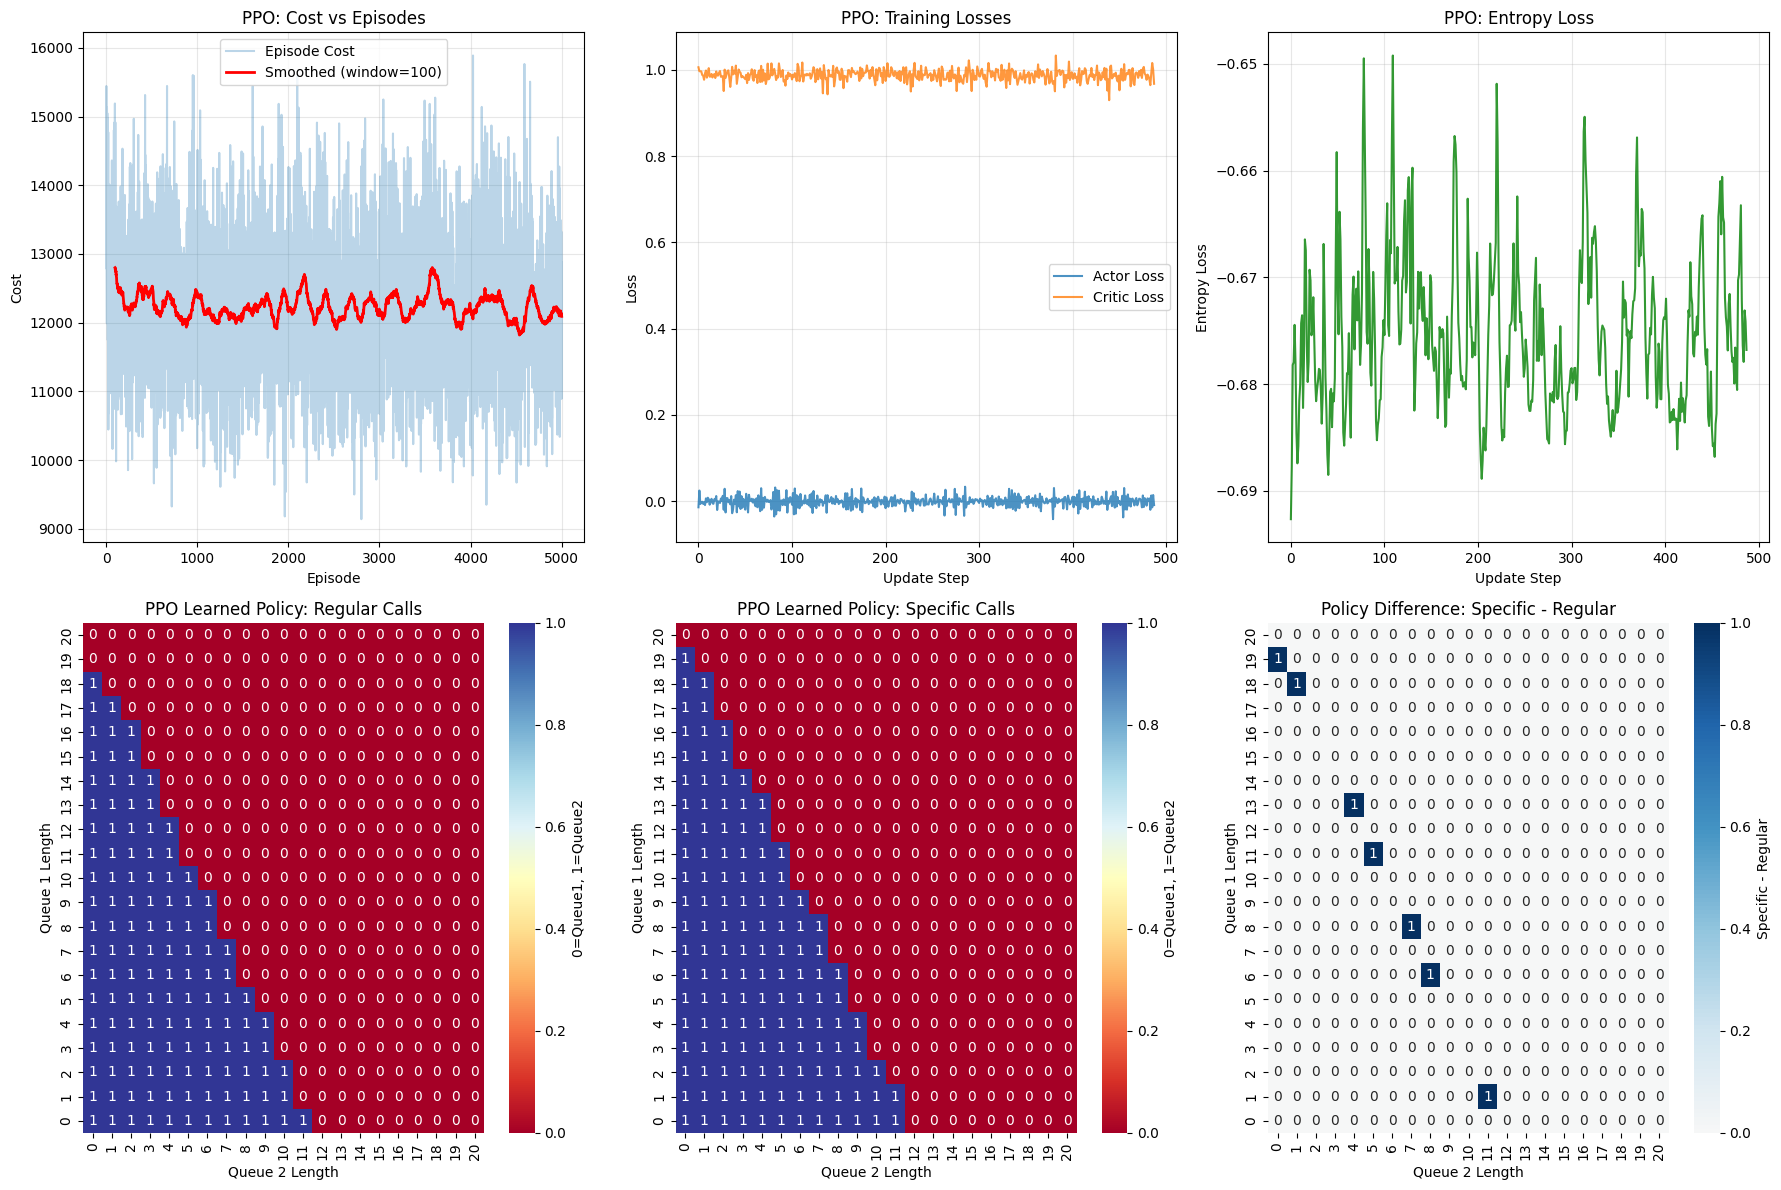

In [125]:

# Example usage and training script
if __name__ == "__main__":
    # Note: This assumes the CallCentreMDPEnv and other components from the original code are available
    
    print("PPO Call Centre Training and Evaluation")
    print("=" * 60)
    
    # Set parameters for the environment
    max_queue_size = MAX_QUEUE_SIZE
    drop_penalty = DROP_PENALTY

    # Arrival parameters
    arrival_means = {
        0: ARRIVAL_REGULAR,    # Regular calls
        1: ARRIVAL_SPECIFIC    # Specific calls
    }
    
    # Service parameters
    service_means = {
        (1, 0): SERVICE_REGULAR_1,
        (1, 1): SERVICE_SPECIFIC_1,
        (2, 0): SERVICE_REGULAR_2,
        (2, 1): SERVICE_SPECIFIC_2
    }

    print(f"Regular call probability: {p_regular:.3f}")
    print(f"Service times (mean): Q1 Regular = {service_means[(1,0)]:.1f} s, Specific = {service_means[(1,1)]:.1f} s")
    print(f"                     Q2 Regular = {service_means[(2,0)]:.1f} s, Specific = {service_means[(2,1)]:.1f} s")
    print(f"Arrival times (mean inter-arrival time): Regular = {arrival_means[0]:.1f} s, Specific = {arrival_means[1]:.1f} s")
    print("="*60)

    # Set random seeds for reproducibility
    random.seed(1901448)
    np.random.seed(1901448)

    # Arrival scaler
    scaler = 10.0  # Adjust this to get more arrivals per episode

    # Create environment with consistent drop penalty, matching your notebook/class signature
    env = CallCentreMDPEnv(
        max_queue_size=max_queue_size,
        drop_penalty=drop_penalty,
        time_step=100.0,  # 100 second time step
        arrival_regular_mean=arrival_means[0] / scaler,
        arrival_specific_mean=arrival_means[1] / scaler,
        service_regular_1=service_means[(1, 0)],
        service_specific_1=service_means[(1, 1)],
        service_regular_2=service_means[(2, 0)],
        service_specific_2=service_means[(2, 1)],
    )

    # Test environment with a few random steps
    print("\nTesting environment:")
    state, _ = env.reset()
    print(f"Initial state: {state}")

    for i in range(3):
        action = random.choice([0, 1])
        state, reward, terminated, truncated, info = env.step(action)
        cost = -reward
        print(f"Step {i+1}: Action={action+1}, State={state}, Cost={cost:.1f}, Dropped={info['dropped']}")

    print("\n" + "="*60)
    
    # Train PPO agent
    agent, episode_rewards, episode_costs, training_losses = train_ppo_agent(
        env,
        num_episodes=5000,
        update_frequency=2048,
        lr=1e-4,
        k_epochs=10,
        entropy_coef=0.1,
        eps_clip=0.1
    )
    
    # Extract learned policies
    policy_regular, policy_specific = extract_ppo_policy(env, agent, max_queue_size=max_queue_size)
    
    # Plot results
    plot_ppo_results(episode_costs, training_losses, policy_regular, policy_specific, max_queue_size=max_queue_size)
    

### What to implement next:

* Implement Gym Environment
* Implement Q-Learning
* Implement PPO